In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [39]:

# The images are 28x28 in black and white. Pixel values will range from 0 to 255.
# First transform, the pixels from 0 to 255 into 0 to 1
# Then we are normalizing the values from the current 0 to 1, iunto -1 to 1

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train = datasets.FashionMNIST(
    root      = "./data",
    train     = True,
    download  = True,
    transform = transform
)

test = datasets.FashionMNIST(
    root      = "./data",
    train     = False,
    download  = True,
    transform = transform
)

<class 'torchvision.datasets.mnist.FashionMNIST'>
Number of images in training ->  60000
Data type of image ->  <class 'torch.Tensor'>
Data type of label ->  <class 'int'>
Image Shape ->  torch.Size([1, 28, 28])
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


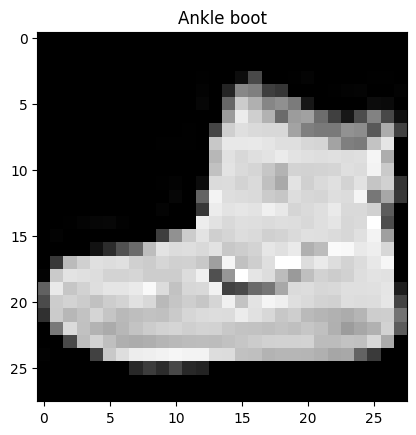

In [40]:
import matplotlib.pyplot as plt

print(type(train))
print("Number of images in training -> ", len(train))

# Check one of the images
img, label = train[0]

print("Data type of image -> ", type(img))
print("Data type of label -> ", type(label))

print("Image Shape -> ", img.shape)

print(train.classes)

img, label = train[0]

plt.imshow(img.squeeze(), cmap="gray")
plt.title(train.classes[label])
plt.show()

In [41]:
train_size = int(0.8 * len(train))
val_size = len(train) - train_size

train, validation = random_split(train, [train_size, val_size])

train_loader = DataLoader(train, batch_size      = 64, shuffle = True)
val_loader   = DataLoader(validation, batch_size = 64)
test_loader  = DataLoader(test, batch_size       = 64)

In [42]:
class BaselineMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)

In [43]:
class DeepMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256), # Making it wider than BaselineMLP which was 128
            nn.ReLU(),
            nn.Linear(256, 256), # Making it deeper with one more layer
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.model(x)

In [44]:
class RegularizedMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)

In [45]:
def train_model(model, optimizer, epochs=5):
    criterion = nn.CrossEntropyLoss()
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

In [46]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [47]:
import torch

def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

In [48]:
!pip install torchinfo


In [49]:
model = BaselineMLP()

# See the model and its details
print(model)

from torchinfo import summary

summary(model, input_size=(64, 1, 28, 28)) # 28x28 is the size, 1 is the blac/white channel, 64 is batch size

total_parameters = 0
for p in model.parameters():
    print("# of parameters -> ", p.numel())
    total_parameters = total_parameters + p.numel()

print("Total parameters -> ", total_parameters)

# Now we optimize

optimizer = optim.SGD(model.parameters(), lr = 0.01)
# I tried with lr 0.001 but it was slow and probably I need more epochs, so I am using 0.01

train_model(model, optimizer, epochs = 5)

print("Validation Accuracy -> ", evaluate(model, val_loader))
print("Test Accuracy       -> ", evaluate(model, test_loader))

BaselineMLP(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)
# of parameters ->  100352
# of parameters ->  128
# of parameters ->  1280
# of parameters ->  10
Total parameters ->  101770
Epoch 1, Loss: 0.8611
Epoch 2, Loss: 0.5448
Epoch 3, Loss: 0.4894
Epoch 4, Loss: 0.4593
Epoch 5, Loss: 0.4394
Validation Accuracy ->  84.26666666666667
Test Accuracy       ->  83.62


In [50]:
y_true, y_pred = get_predictions(model, test_loader)

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[832   2  19  45   3   4  85   0  10   0]
 [  6 950  11  25   4   0   3   0   1   0]
 [ 21   2 793   9  98   1  68   0   8   0]
 [ 40  16  19 854  27   0  41   0   3   0]
 [  0   2 135  38 710   0 110   0   5   0]
 [  0   0   0   2   0 894   0  58   6  40]
 [161   1 140  33  74   0 563   0  28   0]
 [  0   0   0   0   0  39   0 897   0  64]
 [  1   1  15  10   2   9  24   4 932   2]
 [  0   0   0   0   0  21   0  41   1 937]]


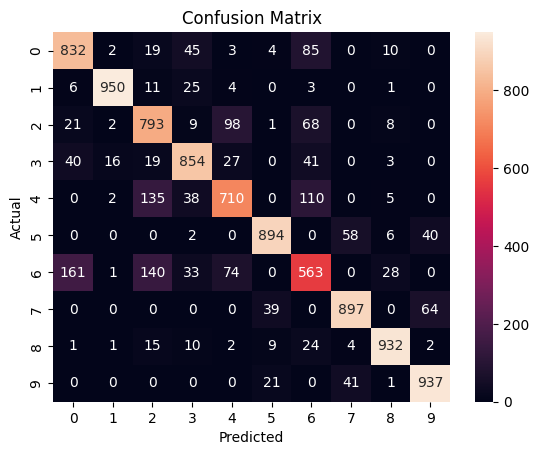

In [52]:
plt.figure()
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [53]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.83      0.81      1000
           1       0.98      0.95      0.96      1000
           2       0.70      0.79      0.74      1000
           3       0.84      0.85      0.85      1000
           4       0.77      0.71      0.74      1000
           5       0.92      0.89      0.91      1000
           6       0.63      0.56      0.59      1000
           7       0.90      0.90      0.90      1000
           8       0.94      0.93      0.93      1000
           9       0.90      0.94      0.92      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [54]:
model = DeepMLP()

# See the model and its details
print(model)

from torchinfo import summary

summary(model, input_size=(64, 1, 28, 28)) # 28x28 is the size, 1 is the blac/white channel, 64 is batch size

total_parameters = 0
for p in model.parameters():
    print("# of parameters -> ", p.numel())
    total_parameters = total_parameters + p.numel()

print("Total parameters -> ", total_parameters)

# Now we optimize

optimizer = optim.Adam(model.parameters(), lr = 0.001)

train_model(model, optimizer, epochs = 5)

print("Validation Accuracy -> ", evaluate(model, val_loader))
print("Test Accuracy       -> ", evaluate(model, test_loader))

DeepMLP(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=10, bias=True)
  )
)
# of parameters ->  200704
# of parameters ->  256
# of parameters ->  65536
# of parameters ->  256
# of parameters ->  2560
# of parameters ->  10
Total parameters ->  269322
Epoch 1, Loss: 0.5094
Epoch 2, Loss: 0.3800
Epoch 3, Loss: 0.3376
Epoch 4, Loss: 0.3128
Epoch 5, Loss: 0.2906
Validation Accuracy ->  87.09166666666667
Test Accuracy       ->  86.68


In [55]:
y_true, y_pred = get_predictions(model, test_loader)

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[785   2  21  20   7   5 151   0   9   0]
 [  3 970   2  19   3   0   1   0   2   0]
 [ 15   1 777  10 114   1  80   0   2   0]
 [ 25   5  10 839  73   1  42   0   5   0]
 [  0   0  80  15 847   0  57   0   1   0]
 [  0   0   0   1   0 929   0  36   0  34]
 [ 82   1  85  21  95   1 707   0   8   0]
 [  0   0   0   0   0  26   0 885   0  89]
 [  2   0   7   5   5   5  18   5 952   1]
 [  0   0   0   0   0   4   1  18   0 977]]


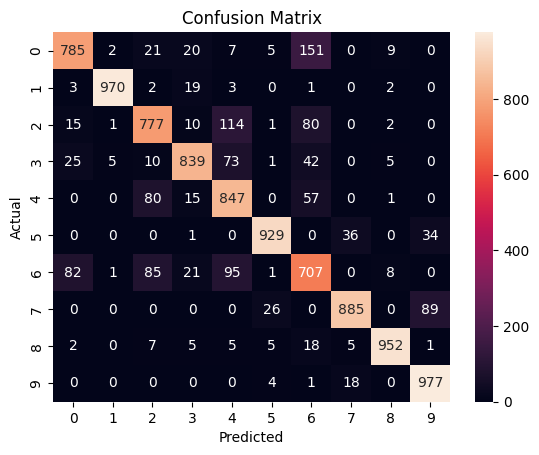

In [57]:
plt.figure()
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [58]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.79      0.78      0.78      1000
           3       0.90      0.84      0.87      1000
           4       0.74      0.85      0.79      1000
           5       0.96      0.93      0.94      1000
           6       0.67      0.71      0.69      1000
           7       0.94      0.89      0.91      1000
           8       0.97      0.95      0.96      1000
           9       0.89      0.98      0.93      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [59]:
model = RegularizedMLP()

# See the model and its details
print(model)

from torchinfo import summary

summary(model, input_size=(64, 1, 28, 28)) # 28x28 is the size, 1 is the blac/white channel, 64 is batch size

total_parameters = 0
for p in model.parameters():
    print("# of parameters -> ", p.numel())
    total_parameters = total_parameters + p.numel()

print("Total parameters -> ", total_parameters)

# Now we optimize

optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.0001)

train_model(model, optimizer, epochs = 5)

print("Validation Accuracy -> ", evaluate(model, val_loader))
print("Test Accuracy       -> ", evaluate(model, test_loader))

RegularizedMLP(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)
# of parameters ->  200704
# of parameters ->  256
# of parameters ->  256
# of parameters ->  256
# of parameters ->  32768
# of parameters ->  128
# of parameters ->  128
# of parameters ->  128
# of parameters ->  1280
# of parameters ->  10
Total parameters ->  235914
Epoch 1, Loss: 0.6427
Epoch 2, Loss: 0.4828
Epoch 3, Loss: 0.4472
Epoch 4, Loss: 0.4263
Epoch 5, Loss: 0.4117
Validation Accuracy ->  87.29166666666667
Test Accuracy

In [60]:
y_true, y_pred = get_predictions(model, test_loader)

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[827   1  17  48   6   5  87   0   9   0]
 [  4 958   3  27   4   0   2   0   2   0]
 [ 16   0 816  13 101   0  50   0   4   0]
 [ 20   4  11 898  33   1  29   0   4   0]
 [  1   0 110  28 799   1  56   0   5   0]
 [  0   0   0   0   0 932   0  27   3  38]
 [143   1 111  37  83   1 610   0  14   0]
 [  0   0   0   0   0  33   0 904   0  63]
 [  1   0   5   5   5   6   5   3 970   0]
 [  0   0   0   0   0   2   1  25   0 972]]


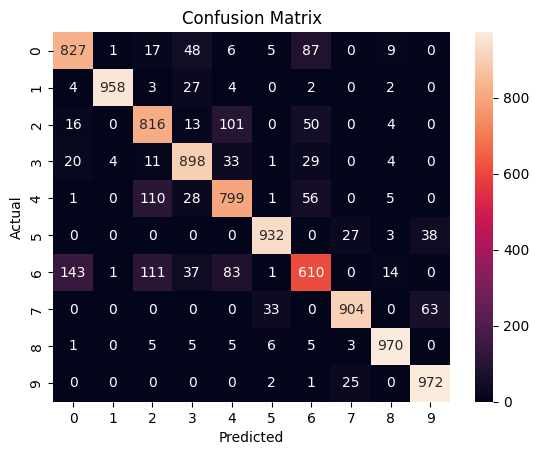

In [62]:
plt.figure()
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [63]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1000
           1       0.99      0.96      0.98      1000
           2       0.76      0.82      0.79      1000
           3       0.85      0.90      0.87      1000
           4       0.77      0.80      0.79      1000
           5       0.95      0.93      0.94      1000
           6       0.73      0.61      0.66      1000
           7       0.94      0.90      0.92      1000
           8       0.96      0.97      0.96      1000
           9       0.91      0.97      0.94      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [64]:
class TunableMLP(nn.Module):
    def __init__(self, hidden_size = 128, dropout = 0.0):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 10)
        )

    def forward(self, x):
        return self.model(x)

In [65]:
y_true, y_pred = get_predictions(model, test_loader)

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[827   1  17  48   6   5  87   0   9   0]
 [  4 958   3  27   4   0   2   0   2   0]
 [ 16   0 816  13 101   0  50   0   4   0]
 [ 20   4  11 898  33   1  29   0   4   0]
 [  1   0 110  28 799   1  56   0   5   0]
 [  0   0   0   0   0 932   0  27   3  38]
 [143   1 111  37  83   1 610   0  14   0]
 [  0   0   0   0   0  33   0 904   0  63]
 [  1   0   5   5   5   6   5   3 970   0]
 [  0   0   0   0   0   2   1  25   0 972]]


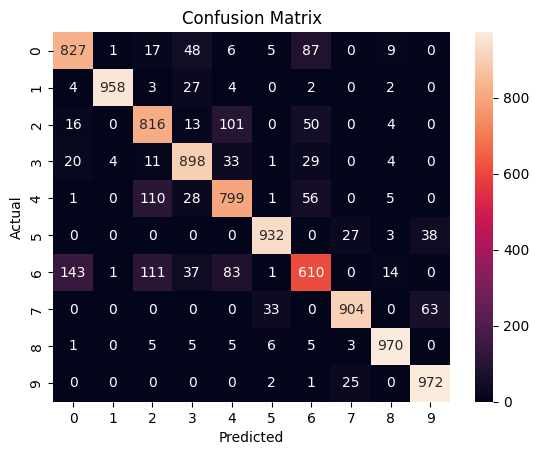

In [67]:
plt.figure()
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [68]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1000
           1       0.99      0.96      0.98      1000
           2       0.76      0.82      0.79      1000
           3       0.85      0.90      0.87      1000
           4       0.77      0.80      0.79      1000
           5       0.95      0.93      0.94      1000
           6       0.73      0.61      0.66      1000
           7       0.94      0.90      0.92      1000
           8       0.96      0.97      0.96      1000
           9       0.91      0.97      0.94      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [69]:
def train_model(model, optimizer, train_loader, epochs = 5):
    criterion = nn.CrossEntropyLoss()
    model.train()

    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

In [70]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total   = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [71]:
# Adam optimizer
learning_rates = [0.01, 0.001]
hidden_sizes   = [128, 256]
dropout_rates  = [0.0, 0.5]

results = []

for lr in learning_rates:
    for hidden in hidden_sizes:
        for dropout in dropout_rates:

            print(f"\nTraining with lr={lr}, hidden = {hidden}, dropout = {dropout}")

            model = TunableMLP(hidden_size=hidden, dropout=dropout).to(device)

            optimizer = optim.Adam(model.parameters(), lr = lr)

            train_model(model, optimizer, train_loader, epochs = 5)

            val_acc = evaluate(model, val_loader)

            print("Validation Accuracy -> ", val_acc)

            results.append({
                "lr": lr,
                "hidden": hidden,
                "dropout": dropout,
                "val_acc": val_acc
            })


Training with lr=0.01, hidden = 128, dropout = 0.0
Validation Accuracy ->  84.51666666666667

Training with lr=0.01, hidden = 128, dropout = 0.5
Validation Accuracy ->  82.5

Training with lr=0.01, hidden = 256, dropout = 0.0
Validation Accuracy ->  82.53333333333333

Training with lr=0.01, hidden = 256, dropout = 0.5
Validation Accuracy ->  81.25833333333334

Training with lr=0.001, hidden = 128, dropout = 0.0
Validation Accuracy ->  87.475

Training with lr=0.001, hidden = 128, dropout = 0.5
Validation Accuracy ->  86.25

Training with lr=0.001, hidden = 256, dropout = 0.0
Validation Accuracy ->  87.7

Training with lr=0.001, hidden = 256, dropout = 0.5
Validation Accuracy ->  86.31666666666666


In [72]:
# Adam optimizer
best_model    = None
best_accuracy = 0

for result in results:
    if result["val_acc"] > best_accuracy:
        best_accuracy = result["val_acc"]
        best_model    = result

print("Best Configuration -> ", best_model)

Best Configuration ->  {'lr': 0.001, 'hidden': 256, 'dropout': 0.0, 'val_acc': 87.7}


In [73]:
# SGD optimizer
learning_rates = [0.01, 0.001]
hidden_sizes   = [128, 256]
dropout_rates  = [0.0, 0.5]

results = []

for lr in learning_rates:
    for hidden in hidden_sizes:
        for dropout in dropout_rates:

            print(f"\nTraining with lr={lr}, hidden = {hidden}, dropout = {dropout}")

            model = TunableMLP(hidden_size=hidden, dropout=dropout).to(device)

            optimizer = optim.SGD(model.parameters(), lr = lr)

            train_model(model, optimizer, train_loader, epochs = 5)

            val_acc = evaluate(model, val_loader)

            print("Validation Accuracy -> ", val_acc)

            results.append({
                "lr": lr,
                "hidden": hidden,
                "dropout": dropout,
                "val_acc": val_acc
            })


Training with lr=0.01, hidden = 128, dropout = 0.0
Validation Accuracy ->  84.04166666666667

Training with lr=0.01, hidden = 128, dropout = 0.5
Validation Accuracy ->  83.33333333333333

Training with lr=0.01, hidden = 256, dropout = 0.0
Validation Accuracy ->  84.16666666666667

Training with lr=0.01, hidden = 256, dropout = 0.5
Validation Accuracy ->  83.71666666666667

Training with lr=0.001, hidden = 128, dropout = 0.0
Validation Accuracy ->  75.35833333333333

Training with lr=0.001, hidden = 128, dropout = 0.5
Validation Accuracy ->  74.71666666666667

Training with lr=0.001, hidden = 256, dropout = 0.0
Validation Accuracy ->  76.0

Training with lr=0.001, hidden = 256, dropout = 0.5
Validation Accuracy ->  75.425
